# 🔬 W02 — AFICv Feature Selection Evaluation
**Objective**: Test the alternative AFICv (Aggregated Feature Importances with Cross-Validation) method from Section III-B4 (Eq. 13) and compare with correlation-based selection.

**Method**: For each fold k of K-fold CV, a base learner computes feature importances. Aggregated importance is:

$$\bar{I}_j = \frac{1}{K} \sum_{k=1}^{K} I_j^{(k)}$$

Features are ranked and a cumulative 70% threshold is applied.

**Author**: Fatima Khadija Benzine  
**Date**: February 2026

---
## 0. Setup

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src'))

from data_loader import MultiDatasetLoader
from preprocessing import PreprocessingPipelineBI, DataNormalizer
from bi_fusion import BIFusionPipeline, BI_FEATURE_NAMES, CATEGORICAL_BI_VARS
from feature_selection import BIAwareFeatureSelector
from feature_selection_aficv import AFICvFeatureSelector

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

print("All modules imported ✓")

All modules imported ✓


---
## 1. Prepare Fused Data
We need the fused (sensor + BI) data BEFORE feature selection, so we run normalization and fusion only.

In [2]:
loader = MultiDatasetLoader()
fd001 = loader.load_fd001()
train_raw = fd001['train'].copy()

# Clip RUL
train_raw['rul'] = train_raw['rul'].clip(upper=125)

# Normalize sensor + settings
sensor_cols = [c for c in train_raw.columns if c.startswith('sensor_')]
setting_cols = [c for c in train_raw.columns if c.startswith('setting_')]
normalizer = DataNormalizer(method='minmax')
train_norm = normalizer.fit_transform(train_raw, sensor_cols + setting_cols)

# Fuse with BI
fusion = BIFusionPipeline()
train_fused = fusion.fuse(train_norm, 'FD001', split='train', encode_categoricals=True)

# Identify column groups
bi_cols = fusion.get_bi_columns(train_fused)
all_feature_cols = sensor_cols + setting_cols + bi_cols
meta_cols = ['unit', 'cycle', 'rul']

print(f"\nFused data: {train_fused.shape}")
print(f"Features: {len(sensor_cols)} sensor + {len(setting_cols)} setting + {len(bi_cols)} BI = {len(all_feature_cols)}")

Loading FD001 dataset...
  Files: train=True, test=True, rul=True
  - Training data shape: (20631, 26)
  - Training units: 100
  - Training RUL range: [0, 361]
  - Test data shape: (13096, 26)
  - RUL values shape: (100, 1)
  - Test units found: 100 (units: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]...)
  - RUL values provided: 100
    Unit 1: max_cycle=31, base_RUL=112
    Unit 2: max_cycle=49, base_RUL=98
    Unit 3: max_cycle=126, base_RUL=69
✓ FD001 loaded: 20631 train, 13096 test samples

=== BI Fusion: FD001 (train) ===
  Sensor data: (20631, 27)
  BI data loaded: 20631 rows, 100 units
  Fused data: (20631, 44)
  Features: 21 sensor + 17 BI

Fused data: (20631, 44)
Features: 21 sensor + 3 setting + 17 BI = 41


---
## 2. Method A: Correlation-Based Selection (baseline)

In [3]:
corr_selector = BIAwareFeatureSelector(
    variance_threshold=0.01,
    correlation_threshold=0.95
)

corr_selected = corr_selector.select_features(
    data=train_fused,
    sensor_cols=sensor_cols,
    bi_cols=bi_cols,
    setting_cols=setting_cols,
    exclude_cols=meta_cols,
)

print(f"\nCorrelation-based: {len(corr_selected)} features")


=== BI-Aware Feature Selection ===
  Input: 21 sensor + 17 BI + 3 setting = 41 total
  Variance filter (sensor/settings only):
    Removed 9: ['sensor_1', 'sensor_5', 'sensor_9', 'sensor_10', 'sensor_14', 'sensor_16', 'sensor_18', 'sensor_19', 'setting_3']
    Kept 15 sensor/setting features
    BI features: 17 (all exempt, all kept)
  Correlation filter (tau=0.95):
    Removed 0:
  Final: 32 features (15 sensor/setting + 17 BI)

Correlation-based: 32 features


---
## 3. Method B: AFICv Selection

In [4]:
aficv_selector = AFICvFeatureSelector(
    base_learner='xgboost',
    n_folds=5,
    cumulative_threshold=0.70,
)

aficv_selected = aficv_selector.select_features(
    data=train_fused,
    feature_cols=all_feature_cols,
    target_col='rul',
    group_col='unit',
)

print(f"\nAFICv: {len(aficv_selected)} features")


=== AFICv Feature Selection ===
  Base learner: xgboost
  K-fold: 5
  Cumulative threshold: 70%
  Candidate features: 41
  Fold 1/5: R²=0.8999
  Fold 2/5: R²=0.8836
  Fold 3/5: R²=0.8989
  Fold 4/5: R²=0.8949
  Fold 5/5: R²=0.8924

  Selected 3/41 features (covering 70.0% importance)
  Top 5: ['downtime_penalty', 'sensor_11', 'sensor_4']

AFICv: 3 features


---
## 4. Feature Importance Ranking

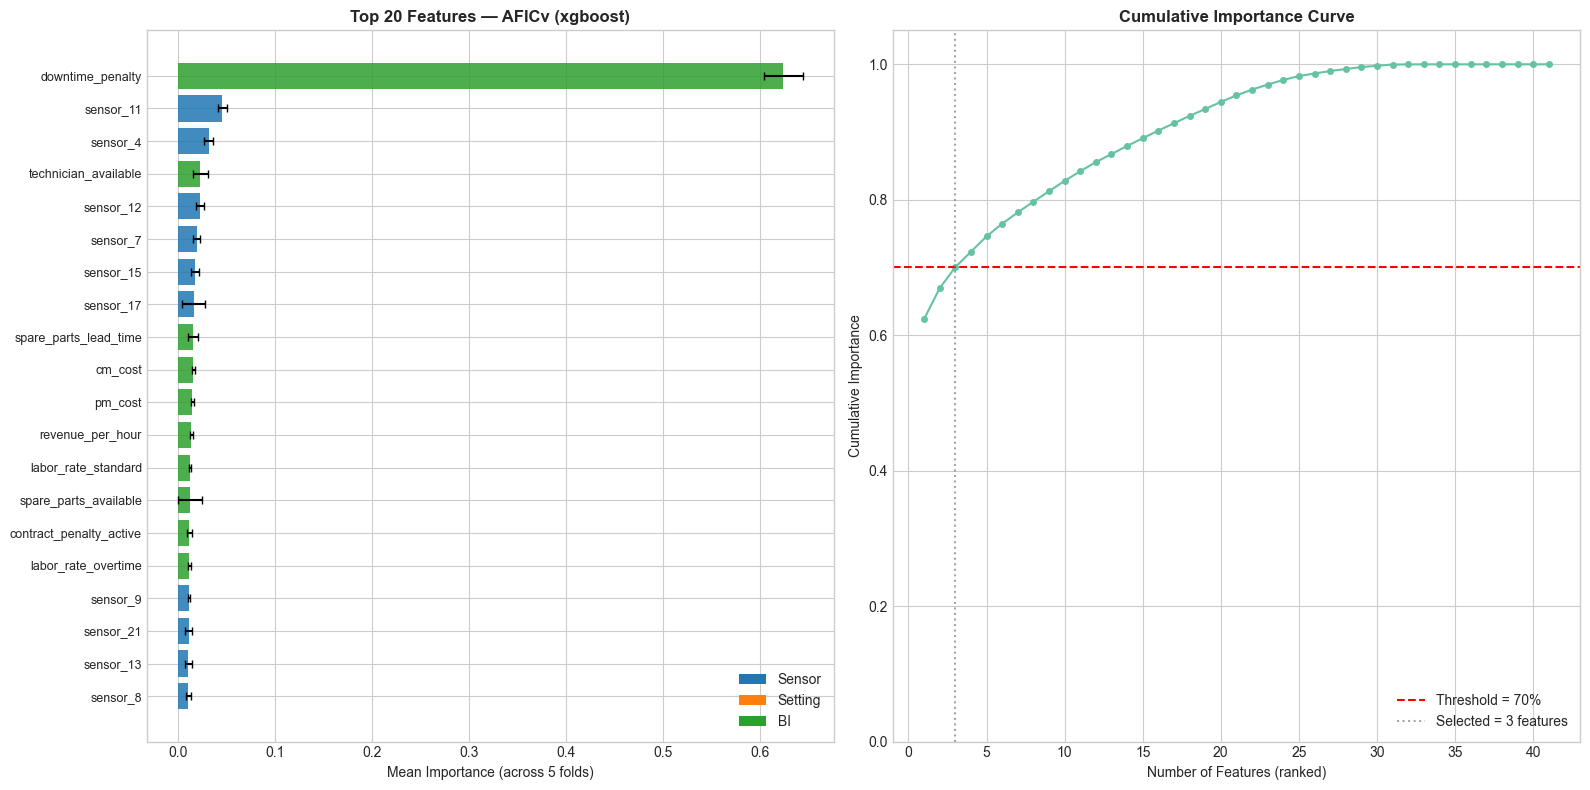

In [5]:
imp = aficv_selector.get_importance_table()

# Color by feature type
def feature_type(name):
    if name.startswith('sensor_'):
        return 'Sensor'
    elif name.startswith('setting_'):
        return 'Setting'
    else:
        return 'BI'

imp['type'] = imp['feature'].apply(feature_type)
type_colors = {'Sensor': '#1f77b4', 'Setting': '#ff7f0e', 'BI': '#2ca02c'}

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: bar chart of importances (top 20)
top_n = min(20, len(imp))
top = imp.head(top_n).iloc[::-1]  # reverse for horizontal bar
colors = [type_colors[t] for t in top['type']]
axes[0].barh(range(top_n), top['mean_importance'], 
             xerr=top['std_importance'], color=colors, alpha=0.85, capsize=3)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top['feature'], fontsize=9)
axes[0].set_xlabel('Mean Importance (across 5 folds)')
axes[0].set_title(f'Top {top_n} Features — AFICv ({aficv_selector.base_learner})', fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=t) for t, c in type_colors.items()]
axes[0].legend(handles=legend_elements, loc='lower right')

# Right: cumulative importance curve
axes[1].plot(range(1, len(imp)+1), imp['cumulative'], 'o-', markersize=4)
axes[1].axhline(y=aficv_selector.cumulative_threshold, color='red', 
                linestyle='--', label=f'Threshold = {aficv_selector.cumulative_threshold*100:.0f}%')
axes[1].axvline(x=len(aficv_selected), color='gray', linestyle=':', alpha=0.7,
                label=f'Selected = {len(aficv_selected)} features')
axes[1].set_xlabel('Number of Features (ranked)')
axes[1].set_ylabel('Cumulative Importance')
axes[1].set_title('Cumulative Importance Curve', fontweight='bold')
axes[1].legend()
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

---
## 5. Compare Methods

In [6]:
corr_set = set(corr_selected)
aficv_set = set(aficv_selected)

common = corr_set & aficv_set
only_corr = corr_set - aficv_set
only_aficv = aficv_set - corr_set

print("=== Method Comparison (FD001) ===")
print(f"\nCorrelation-based: {len(corr_set)} features")
print(f"AFICv:             {len(aficv_set)} features")
print(f"\nCommon:            {len(common)}")
print(f"Only in Corr:      {len(only_corr)} → {sorted(only_corr)}")
print(f"Only in AFICv:     {len(only_aficv)} → {sorted(only_aficv)}")

# Type breakdown
def count_types(features):
    s = sum(1 for f in features if f.startswith('sensor_') or f.startswith('setting_'))
    b = len(features) - s
    return s, b

s_corr, b_corr = count_types(corr_set)
s_aficv, b_aficv = count_types(aficv_set)

print(f"\nType breakdown:")
print(f"  Corr:  {s_corr} sensor/setting + {b_corr} BI")
print(f"  AFICv: {s_aficv} sensor/setting + {b_aficv} BI")

=== Method Comparison (FD001) ===

Correlation-based: 32 features
AFICv:             3 features

Common:            3
Only in Corr:      29 → ['cm_cost', 'contract_penalty_active', 'labor_rate_overtime', 'labor_rate_standard', 'maintenance_window', 'pm_cost', 'production_priority_0', 'production_priority_1', 'production_priority_2', 'revenue_per_hour', 'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_2', 'sensor_20', 'sensor_21', 'sensor_3', 'sensor_6', 'sensor_7', 'sensor_8', 'setting_1', 'setting_2', 'shift_pattern_0', 'shift_pattern_1', 'shift_pattern_2', 'spare_parts_available', 'spare_parts_lead_time', 'technician_available']
Only in AFICv:     0 → []

Type breakdown:
  Corr:  15 sensor/setting + 17 BI
  AFICv: 2 sensor/setting + 1 BI


In [7]:
# Venn-style comparison visualization
all_features = sorted(corr_set | aficv_set)

comparison = pd.DataFrame({
    'feature': all_features,
    'Correlation': ['✓' if f in corr_set else '' for f in all_features],
    'AFICv': ['✓' if f in aficv_set else '' for f in all_features],
    'type': [feature_type(f) for f in all_features],
})

# Add AFICv rank
rank_map = dict(zip(imp['feature'], range(1, len(imp)+1)))
comparison['AFICv_rank'] = comparison['feature'].map(rank_map)

comparison.sort_values('AFICv_rank')

,feature,Correlation,AFICv,type,AFICv_rank
2,downtime_penalty,✓,✓,BI,1
11,sensor_11,✓,✓,Sensor,2
20,sensor_4,✓,✓,Sensor,3
31,technician_available,✓,,BI,4
12,sensor_12,✓,,Sensor,5
22,sensor_7,✓,,Sensor,6
14,sensor_15,✓,,Sensor,7
15,sensor_17,✓,,Sensor,8
30,spare_parts_lead_time,✓,,BI,9
0,cm_cost,✓,,BI,10


---
## 6. Sensitivity: Different Base Learners

In [8]:
learners = ['xgboost', 'random_forest', 'gradient_boosting']
learner_results = {}

for learner in learners:
    print(f"\n{'='*50}")
    sel = AFICvFeatureSelector(
        base_learner=learner,
        n_folds=5,
        cumulative_threshold=0.70,
    )
    selected = sel.select_features(
        data=train_fused,
        feature_cols=all_feature_cols,
        target_col='rul',
        group_col='unit',
    )
    learner_results[learner] = {
        'selected': set(selected),
        'n_features': len(selected),
        'importance_df': sel.get_importance_table(),
    }

print(f"\n{'='*50}")
print("\n=== Base Learner Comparison ===")
for l, r in learner_results.items():
    s, b = count_types(r['selected'])
    print(f"  {l:25s}: {r['n_features']} features ({s} sensor/setting + {b} BI)")

# Features selected by ALL learners (consensus)
consensus = learner_results['xgboost']['selected']
for r in learner_results.values():
    consensus = consensus & r['selected']
print(f"\n  Consensus (all 3 agree): {len(consensus)} → {sorted(consensus)}")



=== AFICv Feature Selection ===
  Base learner: xgboost
  K-fold: 5
  Cumulative threshold: 70%
  Candidate features: 41
  Fold 1/5: R²=0.8999
  Fold 2/5: R²=0.8836
  Fold 3/5: R²=0.8989
  Fold 4/5: R²=0.8949
  Fold 5/5: R²=0.8924

  Selected 3/41 features (covering 70.0% importance)
  Top 5: ['downtime_penalty', 'sensor_11', 'sensor_4']


=== AFICv Feature Selection ===
  Base learner: random_forest
  K-fold: 5
  Cumulative threshold: 70%
  Candidate features: 41
  Fold 1/5: R²=0.8973
  Fold 2/5: R²=0.8899
  Fold 3/5: R²=0.9006
  Fold 4/5: R²=0.8859
  Fold 5/5: R²=0.8798

  Selected 1/41 features (covering 91.6% importance)
  Top 5: ['downtime_penalty']


=== AFICv Feature Selection ===
  Base learner: gradient_boosting
  K-fold: 5
  Cumulative threshold: 70%
  Candidate features: 41
  Fold 1/5: R²=0.9031
  Fold 2/5: R²=0.8912
  Fold 3/5: R²=0.8970
  Fold 4/5: R²=0.8978
  Fold 5/5: R²=0.8968

  Selected 1/41 features (covering 90.5% importance)
  Top 5: ['downtime_penalty']


=== Ba

---
## 7. Sensitivity: Different Thresholds


=== AFICv Feature Selection ===
  Base learner: xgboost
  K-fold: 5
  Cumulative threshold: 50%
  Candidate features: 41
  Fold 1/5: R²=0.8999
  Fold 2/5: R²=0.8836
  Fold 3/5: R²=0.8989
  Fold 4/5: R²=0.8949
  Fold 5/5: R²=0.8924

  Selected 1/41 features (covering 62.4% importance)
  Top 5: ['downtime_penalty']

=== AFICv Feature Selection ===
  Base learner: xgboost
  K-fold: 5
  Cumulative threshold: 60%
  Candidate features: 41
  Fold 1/5: R²=0.8999
  Fold 2/5: R²=0.8836
  Fold 3/5: R²=0.8989
  Fold 4/5: R²=0.8949
  Fold 5/5: R²=0.8924

  Selected 1/41 features (covering 62.4% importance)
  Top 5: ['downtime_penalty']

=== AFICv Feature Selection ===
  Base learner: xgboost
  K-fold: 5
  Cumulative threshold: 70%
  Candidate features: 41
  Fold 1/5: R²=0.8999
  Fold 2/5: R²=0.8836
  Fold 3/5: R²=0.8989
  Fold 4/5: R²=0.8949
  Fold 5/5: R²=0.8924

  Selected 3/41 features (covering 70.0% importance)
  Top 5: ['downtime_penalty', 'sensor_11', 'sensor_4']

=== AFICv Feature Selectio

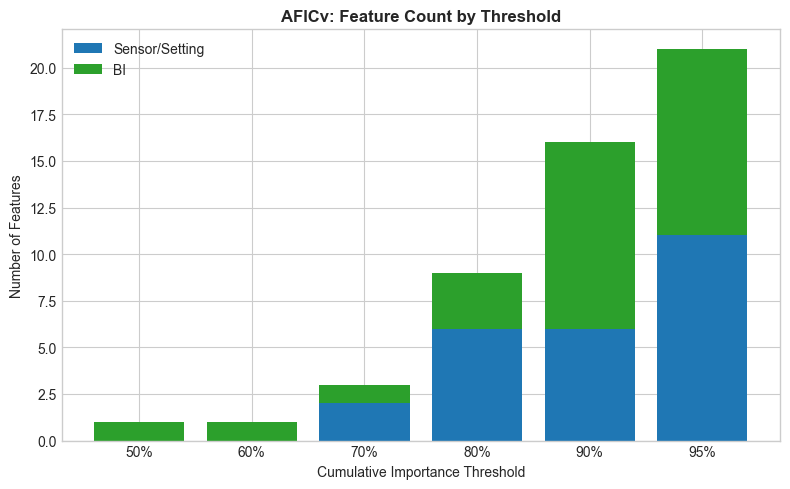

In [9]:
thresholds = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95]
threshold_results = []

for t in thresholds:
    sel = AFICvFeatureSelector(
        base_learner='xgboost',
        n_folds=5,
        cumulative_threshold=t,
    )
    selected = sel.select_features(
        data=train_fused,
        feature_cols=all_feature_cols,
        target_col='rul',
        group_col='unit',
    )
    s, b = count_types(selected)
    threshold_results.append({
        'threshold': f'{t*100:.0f}%',
        'n_features': len(selected),
        'n_sensor_setting': s,
        'n_bi': b,
    })

thresh_df = pd.DataFrame(threshold_results)
print("\n=== Threshold Sensitivity ===")
print(thresh_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar([r['threshold'] for r in threshold_results],
       [r['n_sensor_setting'] for r in threshold_results],
       label='Sensor/Setting', color='#1f77b4')
ax.bar([r['threshold'] for r in threshold_results],
       [r['n_bi'] for r in threshold_results],
       bottom=[r['n_sensor_setting'] for r in threshold_results],
       label='BI', color='#2ca02c')
ax.set_xlabel('Cumulative Importance Threshold')
ax.set_ylabel('Number of Features')
ax.set_title('AFICv: Feature Count by Threshold', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

---
## 8. Summary

| Aspect | Correlation-Based | AFICv |
|:---|:---|:---|
| **Selection criterion** | Variance + pairwise correlation | Learner-based feature importance |
| **BI handling** | Exempt from variance, prioritized in correlation | Treated equally — importance determines selection |
| **Advantages** | Fast, no model training needed | Data-driven, captures nonlinear relationships |
| **Disadvantages** | Only catches linear redundancy | Depends on base learner choice |
| **Methodology ref.** | Eq. 10, 12 | Eq. 13 |

**Key observations to note:**
- Which BI features survive AFICv? (are they the degradation-correlated ones?)
- How stable is the selection across base learners?
- Does the 70% threshold give a reasonable feature count?